# Plotting

### SF Diversity Project - plotting data, descriptive fits, and functional model fits

#### Pick your cell

In [509]:
cellNum = 54;

#### Set constants

In [510]:
import numpy as np
import helper_fcns as hfunc
import model_responses as mod_resp
import autoreload
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline

# save_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/Analysis/Figures'; # local
# data_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/Analysis/Structures/'; # local
save_loc = '/ser/1.2/p2/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/Analysis/Figures/'; # CNS
data_loc = '/ser/1.2/p2/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/Analysis/Structures/'; # CNS
expName = 'dataList.npy';
fitName = 'fitList.npy';
descrName = 'descrFits.npy';
descrModName = 'descrFitsModel.npy';

nFam = 5;
nCon = 2;
plotSteps = 100; # how many steps for plotting descriptive functions?
sfPlot = np.logspace(-1, 1, plotSteps);

dL = np.load(data_loc + expName).item();
fitList = np.load(data_loc + fitName, encoding='latin1'); # no '.item()' because this is array of dictionaries...
descrFits = np.load(data_loc + descrName, encoding='latin1').item();
descrModFits = np.load(data_loc + descrModName, encoding='latin1').item();

In [511]:
autoreload.reload(hfunc);
autoreload.reload(mod_resp);

#### Load data

In [512]:
expData = np.load(data_loc + dL['unitName'][cellNum-1] + '_sfm.npy').item();
modFit = fitList[cellNum-1]['params']; # 
descrFit = descrFits[cellNum-1]['params']; # nFam x nCon x nDescrParams
descrModFit = descrModFits[cellNum-1]['params']; # nFam x nCon x nDescrParams

In [513]:
a, modResp = mod_resp.SFMGiveBof(modFit, expData);
oriModResp, conModResp, sfmixModResp = hfunc.organize_modResp(modResp, expData['sfm']['exp']['trial'])

ha!


##### Plot the main stuff - sfMix experiment with model predictions and descriptive fits

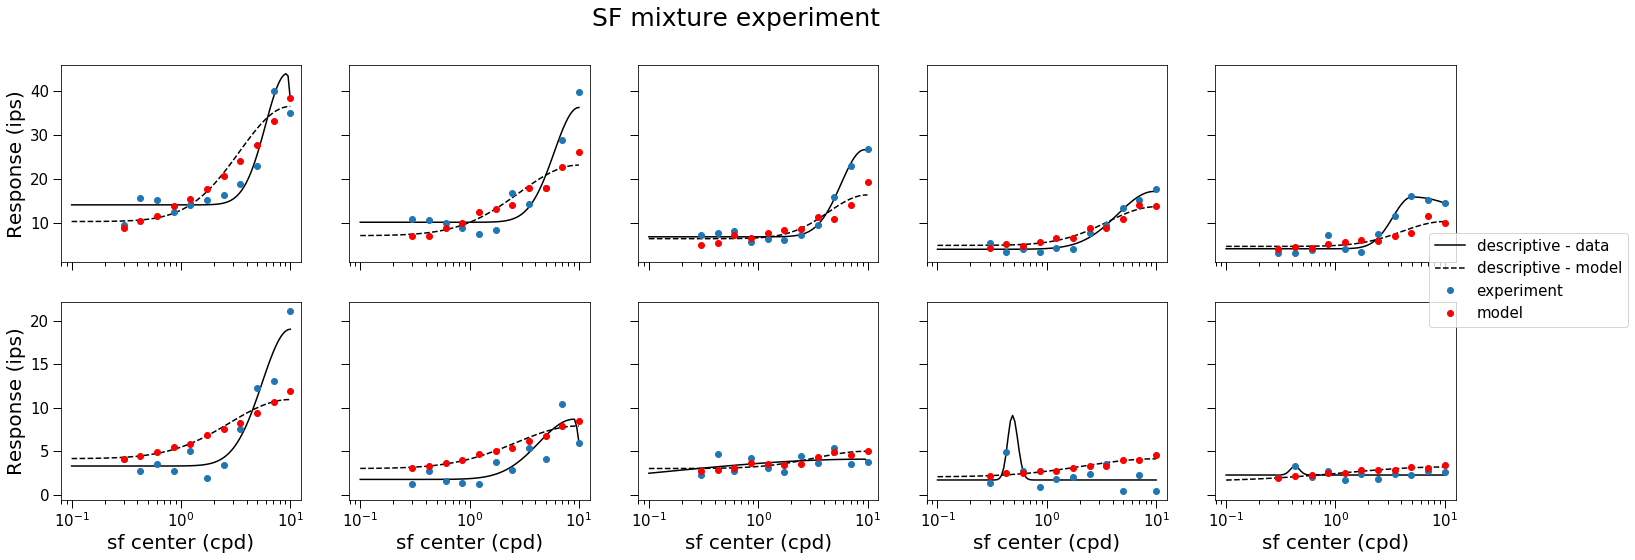

In [514]:
# f, all_plots = plt.subplots(nCon+2, nFam, figsize=(25,25))
f, all_plots = plt.subplots(nCon, nFam, sharex='col', sharey='row', figsize=(25,8))
# why con+2 for number of rows? Want to plot ori/con tuning, model details, too
expSfCent = expData['sfm']['exp']['sf'][0][0];
expResponses = expData['sfm']['exp']['sfRateMean'];

# plot experiment and models
for con in range(nCon): # contrast
    for fam in range(nFam): # family
        dfit = all_plots[con, fam].semilogx(sfPlot, hfunc.flexible_Gauss(descrFit[fam, con, :], sfPlot), 'k-'); # descriptive
        dfitMod = all_plots[con, fam].semilogx(sfPlot, hfunc.flexible_Gauss(descrModFit[fam, con, :], sfPlot), 'k--'); # descriptive
        expPoints = all_plots[con, fam].semilogx(expSfCent, expResponses[fam][con], 'o'); # exp responses
        modPoints = all_plots[con, fam].semilogx(expSfCent, sfmixModResp[fam, con, :], 'ro'); # model responses
        
        # pretty
        all_plots[con,fam].tick_params(labelsize=15, width=1, length=8);
        all_plots[con,fam].tick_params(width=1, length=4, which='minor'); # minor ticks, too...
        if con == 1:
            all_plots[con, fam].set_xlabel('sf center (cpd)', fontsize=20);
        if fam == 0:
            all_plots[con, fam].set_ylabel('Response (ips)', fontsize=20);
            
f.legend((dfit[0], dfitMod[0], expPoints[0], modPoints[0]), ('descriptive - data', 'descriptive - model', 'experiment', 'model'), fontsize = 15, loc='right');
f.suptitle('SF mixture experiment', fontsize=25);

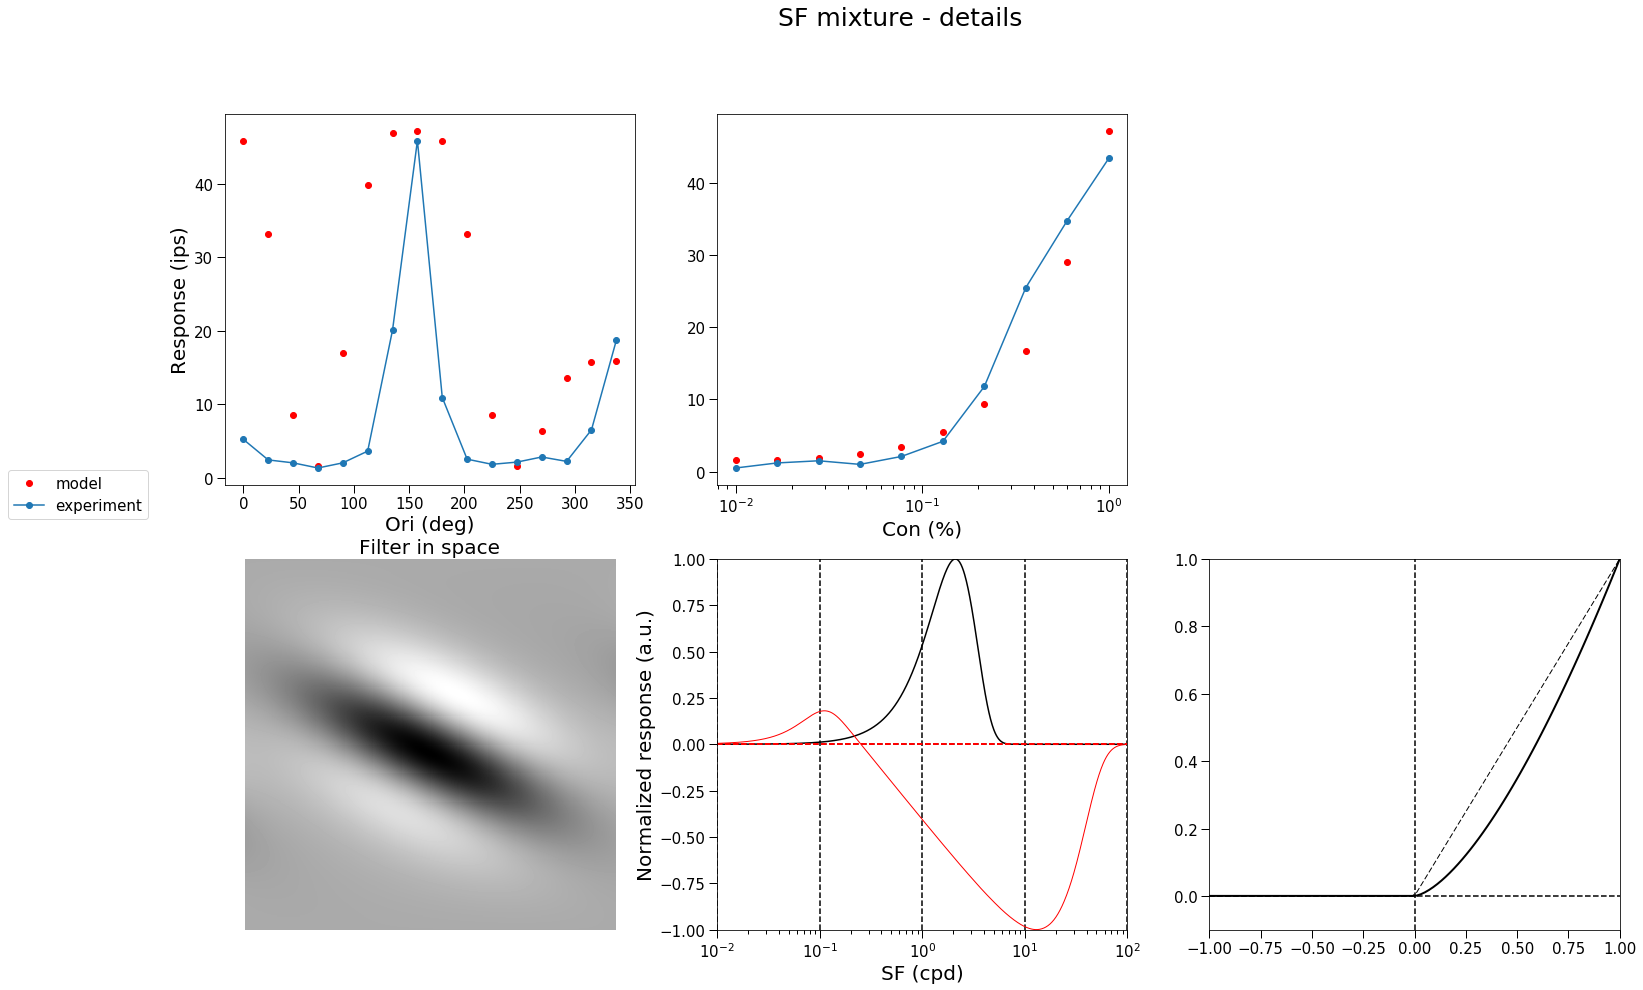

In [462]:
fDetails, all_plots = plt.subplots(2,3, figsize=(25, 15))
# plot ori, CRF tuning
modPlt=all_plots[0, 0].plot(expData['sfm']['exp']['ori'], oriModResp, 'ro'); # Model responses
expPlt=all_plots[0, 0].plot(expData['sfm']['exp']['ori'], expData['sfm']['exp']['oriRateMean'], 'o-'); # Exp responses
all_plots[0, 0].set_xlabel('Ori (deg)', fontsize=20);
all_plots[0, 0].set_ylabel('Response (ips)', fontsize=20);

all_plots[0, 1].semilogx(expData['sfm']['exp']['con'], conModResp, 'ro'); # Model responses
all_plots[0, 1].semilogx(expData['sfm']['exp']['con'], expData['sfm']['exp']['conRateMean'], 'o-'); # Model responses
all_plots[0, 1].set_xlabel('Con (%)', fontsize=20);

all_plots[0,2].axis('off');

# plot model details - filter
imSizeDeg = expData['sfm']['exp']['size'];
pixSize   = 0.0028; # fixed from Robbe
prefSf    = modFit[1];
prefOri   = np.pi/180 * modFit[0];
dOrder    = modFit[3]
aRatio    = modFit[2];
filtTemp  = mod_resp.oriFilt(imSizeDeg, pixSize, prefSf, prefOri, dOrder, aRatio);
filt      = (filtTemp - filtTemp[0])/ np.amax(np.abs(filtTemp - filtTemp[0]));
all_plots[1,0].imshow(filt, cmap='gray');
all_plots[1,0].axis('off');
all_plots[1,0].set_title('Filter in space', fontsize=20)

# plot model details - exc/suppressive components
omega = np.logspace(-2, 2, 1000);

sfRel = omega/prefSf;
s     = np.power(omega, dOrder) * np.exp(-dOrder/2 * np.square(sfRel));
sMax  = np.power(prefSf, dOrder) * np.exp(-dOrder/2);
sfExc = s/sMax;

inhSfTuning = hfunc.getSuppressiveSFtuning();

# Compute weights for suppressive signals
inhChannel = {'gain': modFit[4], 'asym': modFit[11]};
nInhChan = expData['sfm']['mod']['normalization']['pref']['sf'];
inhWeight = [];
for iP in range(len(nInhChan)):
    inhWeight = np.append(inhWeight, 1 + inhChannel['asym']* \
                          (np.log(expData['sfm']['mod']['normalization']['pref']['sf'][iP]) \
                            - np.mean(np.log(expData['sfm']['mod']['normalization']['pref']['sf'][iP]))));
           
sfInh  = np.sum(0.5*modFit[5]*(inhWeight*np.square(inhSfTuning)), 1); # sum is over all filters
sfNorm = np.sum(-.5*(inhWeight*np.square(inhSfTuning)), 1);
sfNorm = sfNorm/np.amax(np.abs(sfNorm));

# just setting up lines
all_plots[1,1].semilogx([omega[0], omega[-1]], [0, 0], 'k--')
all_plots[1,1].semilogx([.01, .01], [-1, 1], 'k--')
all_plots[1,1].semilogx([.1, .1], [-1, 1], 'k--')
all_plots[1,1].semilogx([1, 1], [-1, 1], 'k--')
all_plots[1,1].semilogx([10, 10], [-1, 1], 'k--')
all_plots[1,1].semilogx([100, 100], [-1, 1], 'k--')
# now the real stuff
all_plots[1,1].semilogx(omega, sfExc, 'k-')
all_plots[1,1].semilogx(omega, sfInh, 'r--', linewidth=2);
all_plots[1,1].semilogx(omega, sfNorm, 'r-', linewidth=1);
all_plots[1,1].set_xlim([omega[0], omega[-1]]);
all_plots[1,1].set_ylim([-1, 1]);
all_plots[1, 1].set_xlabel('SF (cpd)', fontsize=20);
all_plots[1, 1].set_ylabel('Normalized response (a.u.)', fontsize=20);

for i in range(len(all_plots)):
    for j in range (len(all_plots[0])):
        all_plots[i,j].tick_params(labelsize=15, width=1, length=8);
        all_plots[i,j].tick_params(width=1, length=4, which='minor'); # minor ticks, too...

# last but not least, response nonlinearity
all_plots[1,2].plot([-1, 1], [0, 0], 'k--')
all_plots[1,2].plot([0, 0], [-.1, 1], 'k--')
all_plots[1,2].plot(np.linspace(-1,1,100), np.power(np.maximum(0, np.linspace(-1,1,100)), modFit[7]), 'k-', linewidth=2)
all_plots[1,2].plot(np.linspace(-1,1,100), np.maximum(0, np.linspace(-1,1,100)), 'k--', linewidth=1)
all_plots[1,2].set_xlim([-1, 1]);
all_plots[1,2].set_ylim([-.1, 1]);
    
    
fDetails.legend((modPlt[0], expPlt[0]), ('model', 'experiment'), fontsize = 15, loc='center left');
fDetails.suptitle('SF mixture - details', fontsize=25);

In [444]:
# and now save it
bothFigs = [f, fDetails];
saveName = "cell%d.pdf" % cellNum
pdf = pltSave.PdfPages(save_loc + saveName)
for fig in range(len(bothFigs)): ## will open an empty extra figure :(
    pdf.savefig(bothFigs[fig])
pdf.close()
